# **Data augmentation vs autoencoder regularisation for 3D subcortical brain segmentation**

# Preliminaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchio seg-metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.7/172.7 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 KB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 KB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=8914f1ccadf1f58c519a38d20ca56c2307f72735a4995e06ce94d5172f24d357
  Stored in directory: /root/.cache/pip/wheels/04/bb/0d/2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleuti

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import torch 
import torch.nn as nn
import time
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader

import pickle
import torchio as tio
import seg_metrics.seg_metrics as sg

import gc # garbage collection, for helping deal with limited memory
#gc.collect()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
subcort_handle = lambda x : f'/content/drive/MyDrive/healthcare_data/subcortical/{x}.npy'
brain_ext_handle = lambda x : f'/content/drive/MyDrive/healthcare_data/brain_extraction/{x}.npy'

# Data Processing

## 2.1 Load and visualise training data

In [9]:
# Processing Guys data

X_Guys  = np.load(subcort_handle("X_Guys"))[:317] # only take scans where there is a brain mask
y_Guys  = np.load(subcort_handle("y_Guys"))[:317]

brain_check_Guys = np.load(brain_ext_handle("X_Guys"))
mask_Guys = np.load(brain_ext_handle("y_Guys"))



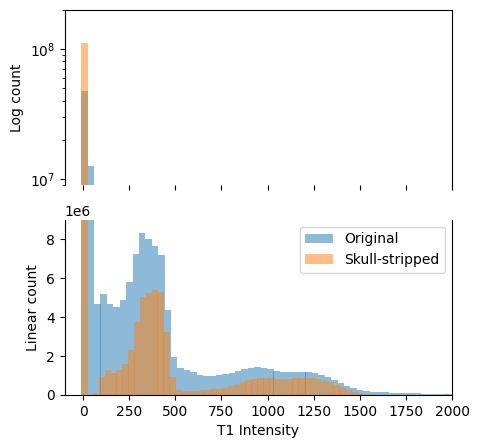

In [10]:
## Generate histogram of intensities before and after skull-stripping
total_Guys = X_Guys.shape[0]
train_num = int(total_Guys * 0.8 )

original, original_centres = np.histogram(X_Guys[:train_num].flatten(), bins = 100)
stripped, stripped_centres = np.histogram((X_Guys * mask_Guys)[:train_num].flatten(), bins = 100)

width = 35
f, (ax, ax2) = plt.subplots(2,sharex = True, facecolor = 'w')

ax.bar(original_centres[1:] , original, alpha=0.5, width=width, label="Original") 
ax.bar(stripped_centres[1:] , stripped, alpha=0.5, width=width, label="Skull-stripped")
ax2.bar(original_centres[1:] , original, alpha=0.5, width=width, label="Original") 
ax2.bar(stripped_centres[1:] , stripped, alpha=0.5, width=width, label="Skull-stripped")

ax.set_ylim([9e6,2e8])
ax.set_yscale("log")
ax.set_ylabel("Log count")
ax2.set_ylim([0, 9e6])
ax2.set_ylabel("Linear count")
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_bottom() 
ax.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()


plt.xlabel("T1 Intensity")
plt.xlim([-100, 2000])
plt.legend()

f.set_size_inches(5, 5)

#plt.savefig("intensity_skulls.jpg", dpi=1200)
plt.show()


In [12]:
## Apply skull stripping masks
assert(np.all((brain_check_Guys - X_Guys)==0))
X_Guys = X_Guys * mask_Guys

X_Guys = np.expand_dims(X_Guys, 1)

# Memory management
brain_check_Guys = None
mask_Guys = None
del brain_check_Guys, mask_Guys
gc.collect()

X_Guys.shape

(317, 1, 40, 128, 128)

In [13]:
def normalize_one_image(x):
    eps = 1e-7
    x_non_zero = x[(x > eps) | (x < -eps)]
    new_x = (x - torch.mean(x_non_zero)) / (torch.std(x_non_zero) + eps)
    return new_x

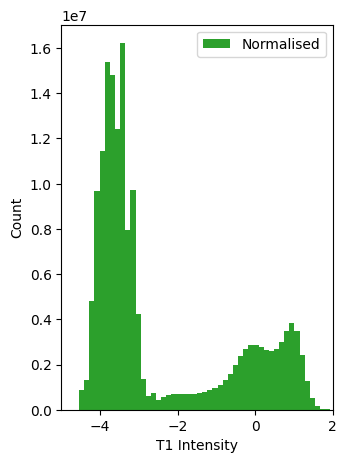

In [14]:
## Generate histogram of normalised intensities

normed = X_Guys[:train_num].copy()
for n in range(len(normed)):
    normed[n] = normalize_one_image(torch.Tensor(normed[n])).numpy()

plt.hist(normed.flatten(), bins=100, color = u'#2ca02c')
plt.xlabel("T1 Intensity")
plt.ylabel("Count")
plt.xlim([-5,2])
plt.legend(["Normalised"])

fig = plt.gcf()
fig.set_size_inches(3.5, 5)

#plt.savefig("intensity_normed.jpg", dpi=1200)
plt.show()

In [16]:
gc.collect()
print(f"Guys data | X shape: {X_Guys.shape} | y shape: {y_Guys.shape} | y label counts: {np.unique(y_Guys[:1], return_counts=True)}") # 
#print(f"IOP data | X shape: {X_IOP.shape} | y shape: {y_IOP.shape}")
#print(f"HH data | X shape: {X_HH.shape} | y shape: {y_HH.shape}")


Guys data | X shape: (317, 1, 40, 128, 128) | y shape: (317, 40, 128, 128) | y label counts: (array([0., 1., 2., 3., 4.]), array([646010,   4594,   2155,   2022,    579]))


In [17]:
def to_one_hot(y, num_classes, remove_first_class = True):
    """ Inefficient version to avoid memory crashes using F.one_hot """
    if remove_first_class:
        store = np.zeros((y.shape[0], num_classes, y.shape[1], y.shape[2], y.shape[3]), dtype=bool)
        for n in range(y.shape[0]):
          print(n, end=' ')
          for i in range(y.shape[1]):
            for j in range(y.shape[2]):
              for k in range(y.shape[3]):
                #print(int(y[n,i,j,k]))
                #print(y[n,i,j,k], int(y[n,i,j,k]), type(y[n,i,j,k]))
                #input()
                if int(y[n,i,j,k]) > 0.1: # index - 1 = ...
                    store[n,int(y[n,i,j,k]) - 1,i,j,k] = True
    else:
        store = np.zeros((y.shape[0], num_classes, y.shape[1], y.shape[2], y.shape[3]), dtype=bool)
        for n in range(y.shape[0]):
          print(n, end=' ')
          for i in range(y.shape[1]):
            for j in range(y.shape[2]):
              for k in range(y.shape[3]):
                store[n,int(y[n,i,j,k]),i,j,k] = True
    return store


gc.collect()

0

In [18]:
y_Guys = to_one_hot(y_Guys, 4, remove_first_class=True)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [19]:
print(y_Guys.shape)
X_Guys.shape

(317, 4, 40, 128, 128)


(317, 1, 40, 128, 128)

In [20]:
from matplotlib.colors import ListedColormap
cmp = ListedColormap(['lime', 'deepskyblue', 'magenta', "darkorange"])

def visualise_brain(brain, x=30, y=64, z=64):
  plt.subplot(1,3,1)
  plt.imshow(np.rot90(brain[0,:,:,z]), cmap='gray')
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(np.rot90(brain[0,:,y,:]), cmap='gray')
  plt.axis('off')
  plt.subplot(1,3,3)
  plt.imshow(np.rot90(brain[0,x,:,:]), cmap='gray')
  plt.axis('off')
  plt.show()

def visualise_brain_with_segmentation(brain, seg, x=30, y=64, z=64, save_name=None):
    fig = plt.figure()
    fig.patch.set_facecolor('black')

    plt.subplot(1,3,1)
    plt.imshow(np.rot90(brain[0,:,:,z]), cmap='gray')
    argmax_seg = np.rot90(np.argmax(seg[:,:,:,z], axis=0))
    
    
    print(np.unique(argmax_seg, return_counts=True))
    transparent = np.rot90(np.max(seg[:,:,:,z], axis=0))
    transparent = np.ma.masked_where(transparent < 0.5, argmax_seg)
    transparent[0,0] = 1
    transparent[0,-1] = 2
    transparent[-1,0] = 3
    transparent[-1,-1] = 4
    plt.imshow(transparent, cmap=cmp, alpha=0.9)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(np.rot90(brain[0,:,y,:]), cmap='gray')
    argmax_seg = np.rot90(np.argmax(seg[:,:,y,:], axis=0))
    transparent = np.rot90(np.max(seg[:,:,y,:], axis=0))
    transparent = np.ma.masked_where(transparent < 0.5, argmax_seg)
    plt.imshow(transparent, cmap=cmp, alpha=0.9)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(np.rot90(brain[0,x,:,:]), cmap='gray')
    argmax_seg = np.rot90(np.argmax(seg[:,x,:,:], axis=0))
    transparent = np.rot90(np.max(seg[:,x,:,:], axis=0))
    transparent = np.ma.masked_where(transparent < 0.5, argmax_seg)
    plt.imshow(transparent, cmap=cmp, alpha=0.9)
    plt.axis('off')


    if save_name is not None:
        plt.savefig(save_name, dpi=1200)
    plt.show()

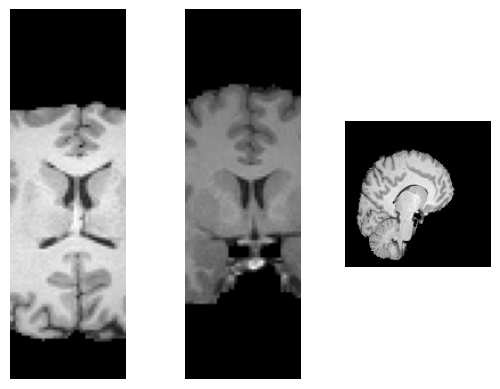

(array([0, 1, 2]), array([4879,  163,   78]))


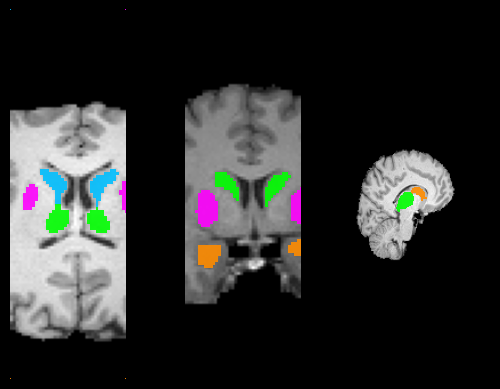

In [22]:
brain = X_Guys[0]
seg = y_Guys[0]
visualise_brain(brain)
visualise_brain_with_segmentation(brain, seg)
del brain, seg

## 2.2 Visualising data augmentation

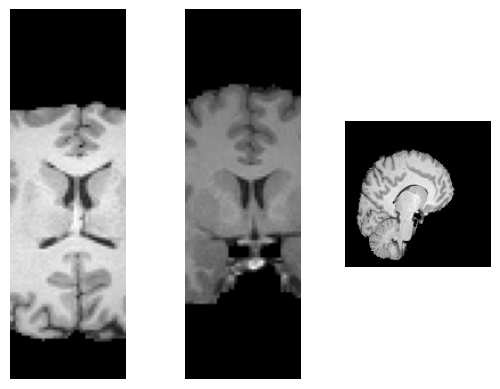

RandomFlip()


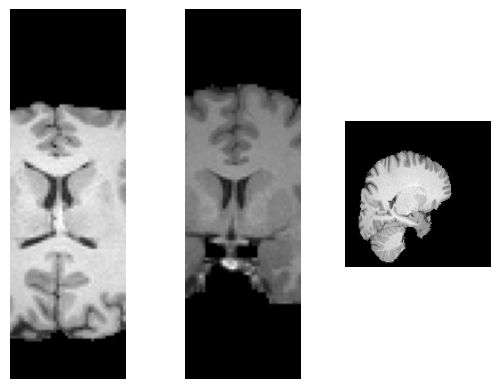

RandomAffine()


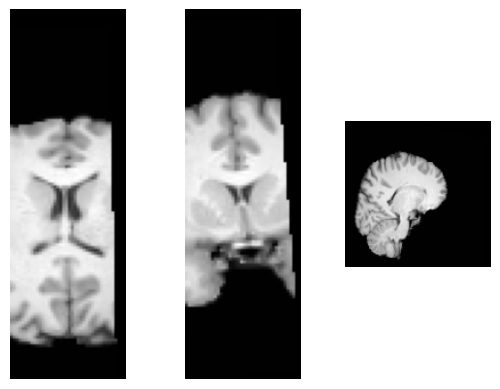

RandomMotion()


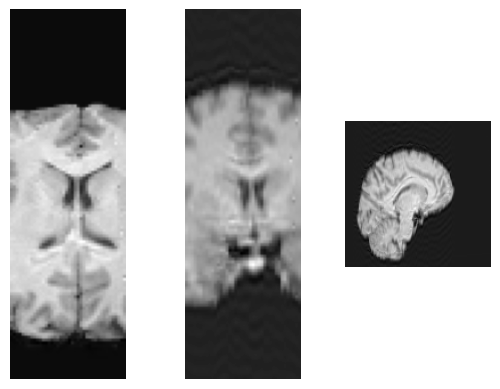

RandomBiasField()


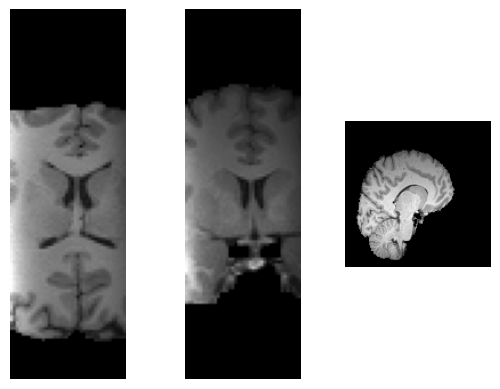

RandomGamma()


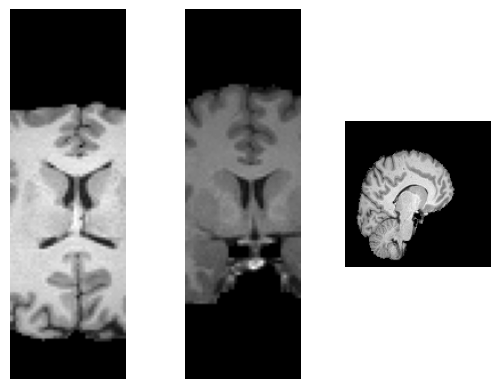

In [35]:
brain = X_Guys[0]

visualise_brain(brain)

spatial_transforms = [
            tio.transforms.RandomFlip(axes=(0,1,2), p=0.5),
            tio.transforms.RandomAffine(scales=(0.9,1.1),degrees=5, translation=5, isotropic=True)
      ]
intensity_transforms = [
            tio.transforms.RandomMotion(degrees=5, translation=5), # p=0.25 for actual dataset
            tio.transforms.RandomBiasField(), # p=0.5 for actual dataset
            tio.transforms.RandomGamma(log_gamma = (-0.3, 0.3))
        ]

for transform in spatial_transforms:
    print(transform)
    visualise_brain(transform(brain))

for transform in intensity_transforms:
    print(transform)
    visualise_brain(transform(brain))


## 2.3 Dataset definition





In [36]:
class custom_dataset(Dataset):
    def __init__(self, data, target, augment_data = False):
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)
        self.augment_data = augment_data
        self.spatial_transforms = [
            tio.transforms.RandomFlip(axes=(0,1,2), p=0.5),
            tio.transforms.RandomAffine(scales=(0.9,1.1),degrees=5, translation=5, isotropic=True, p=0.25)
        ]
        self.intensity_transforms = [
            tio.transforms.RandomMotion(degrees=5, translation=5, p=0.25),
            tio.transforms.RandomBiasField(p=0.25),
            tio.transforms.RandomGamma(log_gamma = (-0.3, 0.3), p=0.25)
        ]
        self.spatial_transform = tio.Compose(self.spatial_transforms)
        self.intensity_transform = tio.Compose(self.intensity_transforms)

    def __getitem__(self, index):
        if self.augment_data:
            x = self.data[index].clone().detach()
            y = self.target[index].clone().detach()
            cat = torch.cat([x,y], dim=0)
            spatially_transformed = self.spatial_transform(cat)
            x = spatially_transformed[:1, :,:,:]
            y = spatially_transformed[1:, :,:,:]
            x = self.intensity_transform(x)
        else:
            x = self.data[index].clone().detach()
            y = self.target[index].clone().detach()
        
        x = normalize_one_image(x)
        return x, y

    def __len__(self):
        return len(self.data)

# Model definition

## 3.1 Defining the model class

In [37]:
class RegUNet(nn.Module):
    def __init__(self, in_channels=1, init_features=32, out_channels=1, vae_path=False):
        super(RegUNet, self).__init__()

        self.vae_path = vae_path
        self.H, self.W, self.D = 40, 128, 128

        features = init_features

        res_conn = lambda _in, _out : nn.Conv3d(_in, _out, (1,1,1), stride=1, padding="same")

        ## Encoder

        self.enc_conv0 = nn.Conv3d(in_channels, features, (3,3,3), stride=1,
                                  padding="same")
        self.enc_dropout1 = nn.Dropout3d(p=0.2, inplace=True)

        self.enc_green_block1_1 = RegUNet._block(features, features)
        self.enc_res1_1 = res_conn(features, features)
        self.enc_conv1 = nn.Conv3d(features, features, (3,3,3), stride=2, padding=1)
        
        self.enc_green_block2_1 = RegUNet._block(features , features * 2)
        self.enc_res2_1 = res_conn(features, features * 2)
        self.enc_green_block2_2 = RegUNet._block(features * 2, features * 2)
        self.enc_res2_2 = res_conn(features * 2, features * 2)
        self.enc_conv2 = nn.Conv3d(features * 2, features * 2, (3,3,3), stride=2, padding=1)
        
        self.enc_green_block4_1 = RegUNet._block(features * 2, features * 4)
        self.enc_res4_1 = res_conn(features * 2, features * 4)
        self.enc_green_block4_2 = RegUNet._block(features * 4, features * 4)
        self.enc_res4_2 = res_conn(features * 4, features * 4)
        self.enc_conv4 = nn.Conv3d(features * 4, features * 4, (3,3,3), stride=2, padding=1)
        
        self.enc_green_block8_1 = RegUNet._block(features * 4, features * 8)
        self.enc_res8_1 = res_conn(features * 4, features * 8)
        self.enc_green_block8_2 = RegUNet._block(features * 8, features * 8)
        self.enc_res8_2 = res_conn(features * 8, features * 8)
        self.enc_green_block8_3 = RegUNet._block(features * 8, features * 8)
        self.enc_res8_3 = res_conn(features * 8, features * 8)
        self.enc_green_block8_4 = RegUNet._block(features * 8, features * 8)
        self.enc_res8_4 = res_conn(features * 8, features * 8) 

        ## Decoder

          ## Ground Truth path

        self.dec_conv4 = nn.Conv3d(features * 8, features * 4, (1,1,1), stride=1,
                                  padding="same")
        self.dec_upsample4 = nn.Upsample(scale_factor = 2, mode="trilinear")
        self.dec_green_block4 = RegUNet._block(features * 4, features * 4)

        self.dec_conv2 = nn.Conv3d(features * 4, features * 2, (1,1,1), stride=1,
                                  padding="same")
        self.dec_upsample2 = nn.Upsample(scale_factor = 2, mode="trilinear")
        self.dec_green_block2 = RegUNet._block(features * 2, features * 2)

        self.dec_conv1 = nn.Conv3d(features * 2, features, (1,1,1), stride=1,
                                  padding="same")
        self.dec_upsample1 = nn.Upsample(scale_factor = 2, mode="trilinear")
        self.dec_green_block1 = RegUNet._block(features, features)

        self.dec_blue_block = nn.Conv3d(features, features, (3,3,3), stride=1,
                                  padding="same")
        
        self.dec_output = nn.Conv3d(features, out_channels, (1,1,1), stride=1,
                                  padding="same")
        
        self.dec_act_out = nn.Sigmoid()

        if self.vae_path:
            self.vae_group_norm = nn.GroupNorm(num_groups=8, num_channels= features * 8)
            self.vae_relu1 = nn.ReLU(inplace=True)
            self.vae_conv1 = nn.Conv3d(features * 8, 16, (3,3,3), stride=2,
                                  padding=1)


            self.vae_flatten = nn.Flatten()
            self.vae_dense_1 = nn.Linear(3072, 256)

            self.vae_z_mean = nn.Linear(256, 128)
            self.vae_z_std  = nn.Linear(256, 128)


            self.vae_dense_2 = nn.Linear(128, in_channels * 
                                (self.W // 8) * (self.H // 8) * (self.D // 8))
            self.vae_dense_2_act = nn.ReLU(inplace=True)
            self.vae_reshape = lambda batch, x : torch.reshape(x, (batch, in_channels, 
                                (self.H // 8), (self.W // 8), (self.D // 8)))
            self.vae_conv2 = nn.Conv3d(in_channels, features * 8, (1,1,1), stride=1,
                                  padding="same")
            #self.vae_upsample2 = nn.Upsample(scale_factor = 2, mode="trilinear")


            self.vae_conv3 = nn.Conv3d(features * 8, features * 4, (1,1,1), stride=1,
                                  padding="same")
            self.vae_upsample3 = nn.Upsample(scale_factor = 2, mode="trilinear")

            self.vae_green_block1 = RegUNet._block(features * 4, features * 4)
            self.vae_res1 = res_conn(features * 4, features * 4)

            self.vae_conv4 = nn.Conv3d(features * 4, features * 2, (1,1,1), stride=1,
                                  padding="same")
            self.vae_upsample4 = nn.Upsample(scale_factor = 2, mode="trilinear")

            self.vae_green_block2 = RegUNet._block(features * 2, features * 2)
            self.vae_res2 = res_conn(features * 2, features * 2)


            self.vae_conv5 = nn.Conv3d(features * 2, features, (1,1,1), stride=1,
                                  padding="same")
            self.vae_upsample5 = nn.Upsample(scale_factor = 2, mode="trilinear")

            self.vae_green_block3 = RegUNet._block(features, features)
            self.vae_res3 = res_conn(features, features)

            self.vae_output = nn.Conv3d(features, in_channels, (1,1,1), stride=1,
                                  padding="same")


# https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
    def sampling(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
          """
          Reparameterization trick to sample from N(mu, var) from
          N(0,1).
          :param mu: (Tensor) Mean of the latent Gaussian [B x D]
          :param logvar: (Tensor)Standard deviation of the latent Gaussian [B x D]
          :return: (Tensor) [B x D]
          """
          std = torch.exp(0.5 * logvar)
          eps = torch.randn_like(std)
          return eps * std + mu      

    def forward(self, x):
        batch_size = x.shape[0]

        # Encoder
        x = self.enc_conv0(x)
        x = self.enc_dropout1( x ) 
        x1 = self.enc_green_block1_1( x ) + self.enc_res1_1( x )
        
        x = self.enc_conv1( x1 )
        x = self.enc_green_block2_1( x ) + self.enc_res2_1( x )
        x2 = self.enc_green_block2_2( x ) + self.enc_res2_2( x )

        x = self.enc_conv2( x2 )
        x = self.enc_green_block4_1( x ) + self.enc_res4_1( x )
        x4 = self.enc_green_block4_2( x ) + self.enc_res4_2( x )

        x = self.enc_conv4( x4 )
        x = self.enc_green_block8_1( x ) + self.enc_res8_1( x )
        x = self.enc_green_block8_2( x ) + self.enc_res8_2( x )
        x = self.enc_green_block8_3( x ) + self.enc_res8_3( x )
        x8 = self.enc_green_block8_4( x ) + self.enc_res8_4( x )

        # Decoder

        x = self.dec_conv4( x8 )
        x = self.dec_upsample4( x )
        x = x + x4
        x = self.dec_green_block4( x ) + x

        x = self.dec_conv2( x )
        x = self.dec_upsample2( x )
        x = x + x2
        x = self.dec_green_block2( x ) + x

        x = self.dec_conv1( x )
        x = self.dec_upsample1( x )
        x = x + x1
        x = self.dec_green_block1( x ) + x

        x = self.dec_blue_block( x )
        x = self.dec_output( x )
        dec_out = self.dec_act_out ( x )

        # VAE Regulariser

        if self.vae_path:
            x = self.vae_relu1( self.vae_group_norm( x8 ) )
            x = self.vae_conv1( x )
      
            x = self.vae_flatten( x )
            x = self.vae_dense_1( x )

            z_mean = self.vae_z_mean( x )
            z_std = self.vae_z_mean( x )

            x = self.sampling( z_mean, z_std )

            x = self.vae_dense_2_act( self.vae_dense_2( x ) )
            x = self.vae_reshape( batch_size, x )
            x = self.vae_conv2( x )
            #x = self.vae_upsample2( x )

            x = self.vae_conv3( x )
            x = self.vae_upsample3( x )

            x = self.vae_green_block1( x ) + self.vae_res1( x )
            x = self.vae_conv4( x )
            x = self.vae_upsample4( x )

            x = self.vae_green_block2( x ) + self.vae_res2( x )
            x = self.vae_conv5( x )
            x = self.vae_upsample5( x )
            
            x = self.vae_green_block3( x ) + self.vae_res3( x )
            vae_out = self.vae_output( x )

            return [dec_out, vae_out, z_mean, z_std]
        else:
            return dec_out

    @staticmethod
    def _block(in_channels, features):
        return nn.Sequential(
            OrderedDict(
                [ ("groupnorm1", nn.GroupNorm(num_groups=8, num_channels=in_channels)),
                  ("relu1", nn.ReLU(True)),
                  ("conv1", nn.Conv3d(in_channels, features, (3,3,3), stride=1,
                                      padding="same")),
                  ("groupnorm2", nn.GroupNorm(num_groups=8, num_channels=features)),
                  ("relu2", nn.ReLU(True)),
                  ("conv2", nn.Conv3d(features, features, (3,3,3), stride=1,
                                      padding="same"))
                 ]
            ))


### 3.1.1 Sanity-checking the model

In [38]:
net = None
output = None
del net, output
gc.collect()

net = RegUNet(in_channels=1, init_features=8, out_channels=4, vae_path=True).to(device)

s = time.time()
output = net(torch.FloatTensor(X_Guys[:1]).to(device))
display(output[0].shape, output[1].shape)
print(time.time() - s)

torch.Size([1, 4, 40, 128, 128])

torch.Size([1, 1, 40, 128, 128])

7.1980979442596436


torch.Size([1, 4, 40, 128, 128])

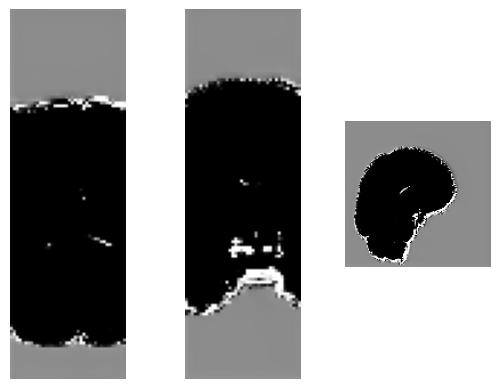

6046

In [39]:
display(output[0].detach().shape)
visualise_brain(output[0][0].cpu().detach())

gc.collect()

## 3.2 Loss functions

In [40]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.eps=1e-7

    def forward(self, x, target):
        num_classes = target.shape[1]
        target = target.type(x.type())
        av_dice_loss = 0
        for cls in range(num_classes):
            dims = tuple(range(target.ndimension() - 1))
            intersection = torch.sum(x[:,cls] * target[:,cls], dims)
            cardinality = torch.sum(torch.square(x[:,cls]) + torch.square(target[:,cls]), dims)
            dice_loss = (2. * intersection / (cardinality + self.eps)).mean()
            av_dice_loss += dice_loss
        return -(av_dice_loss / num_classes)

class KLLoss(nn.Module):
    def __init__(self, input_shape):
        super(KLLoss, self).__init__()
        self.eps=1e-7
        c, H, W, D = input_shape
        self.norm_factor = c * H * W * D

    def forward(self, mean, logvar, batch_size=1):

        loss = (1 / (self.norm_factor * batch_size)) * (
                                    torch.square(mean) + torch.exp(logvar) - logvar - 1.)
        loss = torch.sum(loss)
        return loss

DICE_LOSS = DiceLoss()
L2_LOSS   = nn.MSELoss()
KL_LOSS   = KLLoss(X_Guys.shape[1:])


## 3.3 Train / validate functions

In [41]:
def train(net, dataloader, optim, epoch):
    global DICE_LOSS, L2_LOSS, KL_LOSS, device
    net.train()
    total_loss = 0
    loss_dict = {"dice":0, "L2":0, "KL":0}
    batches = 0
    
    start_time = time.time()

    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data.float()).to(device), Variable(target.float()).to(device)
        batches += 1

        # Training loop
        if net.vae_path:
            seg_pred, reg_pred, mean, logvar = net(data)
            dice_loss = DICE_LOSS(seg_pred, target)
            L2_loss = L2_LOSS(reg_pred, data)
            KL_loss = KL_LOSS(mean, logvar, batch_size=dataloader.batch_size)
            loss = dice_loss + 0.1 * (L2_loss + KL_loss)

            loss_dict["L2"] += torch.mean(L2_loss).cpu().detach().item()
            loss_dict["KL"] += torch.mean(KL_loss).cpu().detach().item()
            
            
        else:
            seg_pred = net(data)
            dice_loss = DICE_LOSS(seg_pred, target)
            loss = dice_loss
        
        loss_dict["dice"] += torch.mean(dice_loss).cpu().detach().item()

        net.zero_grad()
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss
        if batch_idx % 50 == 0: #Report stats every x batches
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx+1) * len(data), len(dataloader.dataset),
                           100. * (batch_idx+1) / len(dataloader), loss.item()), flush=True)
    av_loss = total_loss / batches
    av_loss = av_loss.detach().cpu().numpy()

    loss_dict["dice"] /= batches
    loss_dict["L2"] /= batches
    loss_dict["KL"] /= batches    

    print('\nTraining set: Average loss: {:.4f} | Dice loss: {:.4f} | L2 loss: {:.4f} | KL loss: {:.4f}'.format(av_loss, loss_dict["dice"], loss_dict["L2"], loss_dict["KL"],  flush=True))


    end_time = time.time()
    total_time = end_time - start_time

    print('Time taken for epoch = ', total_time)
    return av_loss, loss_dict



In [42]:
def validate(net, val_dataloader, optim, epoch):
    global DICE_LOSS, L2_LOSS, KL_LOSS, device
    net.eval()
    total_loss = 0
    loss_dict = {"dice":0, "L2":0, "KL":0}
    batches = 0

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_dataloader):
            data, target = Variable(data.float()).to(device), Variable(target.float()).to(device)
            batches += 1

            # Training loop
            if net.vae_path:
                seg_pred, reg_pred, mean, logvar = net(data)
                dice_loss = DICE_LOSS(seg_pred, target)
                L2_loss = L2_LOSS(reg_pred, data)
                KL_loss = KL_LOSS(mean, logvar, batch_size=val_dataloader.batch_size)
                loss_dict["L2"] += torch.mean(L2_loss).cpu().detach().item()
                loss_dict["KL"] += torch.mean(KL_loss).cpu().detach().item()
                loss = dice_loss + 0.1 * (L2_loss + KL_loss)
            else:
                seg_pred = net(data)
                dice_loss = DICE_LOSS(seg_pred, target)
                loss = dice_loss
            
            loss_dict["dice"] += torch.mean(dice_loss).cpu().detach().item()

            total_loss += loss
    
    av_loss = total_loss / batches
    av_loss = av_loss.detach().cpu().item()

    loss_dict["dice"] /= batches
    loss_dict["L2"] /= batches
    loss_dict["KL"] /= batches    

    print('\nValidation set: Average loss: {:.4f} | Dice loss: {:.4f} | L2 loss: {:.4f} | KL loss: {:.4f}'.format(av_loss, loss_dict["dice"], loss_dict["L2"], loss_dict["KL"],  flush=True))

    end_time = time.time()
    total_time = end_time - start_time

    print('Time taken for epoch = ', total_time)
    return av_loss, loss_dict

# Training the model

In [58]:
use_autoencoder = False
use_data_augmentation = False

In [59]:
total_Guys = X_Guys.shape[0]
train_num = int(total_Guys * 0.8 )
val_num = int(total_Guys * 0.1) + train_num

train_dataset = custom_dataset(X_Guys[:train_num], y_Guys[:train_num], 
                               augment_data=use_data_augmentation)
val_dataset = custom_dataset(X_Guys[train_num:val_num], y_Guys[train_num:val_num],
                               augment_data=False)
#test_dataset_Guys = custom_dataset(X_Guys[val_num:], y_Guys[val_num:], augment_data=False)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [60]:
def get_params(net):
    params = 0
    for parameter in net.parameters():
        params += len(nn.Flatten(start_dim=0)(parameter))
    print('Trainable params: ', params)
    return params

In [64]:
load_existing=False
max_epochs = 200
alpha0 = 1e-4

save_directory = "/content/drive/MyDrive/healthcare_data/models_200/"
handle = f"aug={use_data_augmentation}_vae={use_autoencoder}"

loss_file_name = f'{save_directory}losses_{handle}.pickle'

model_last_name = f"{save_directory}{handle}_last_epoch"
model_best_name = f"{save_directory}{handle}_best_model"

In [62]:
net = RegUNet(in_channels=1, init_features=8, out_channels=4,
              vae_path=use_autoencoder).float().to(device)
get_params(net)

if load_existing:
    with open(loss_file_name, 'rb') as handle:
        losses = pickle.load(handle)
    net.load_state_dict(torch.load(model_last_name))
    best_val_loss = min(np.array(losses)[:,4])
    start_epochs = len(losses)
else:
    losses = []
    best_val_loss = np.inf
    start_epochs = 0


alpha = alpha0 * (1- (start_epochs / max_epochs))**0.9
optim = torch.optim.Adam(net.parameters(), lr = alpha, weight_decay=1e-5)

for epoch in range(1+start_epochs, max_epochs+1):
    train_loss, loss_dict = train(net, train_dataloader, optim, epoch)
    val_loss, val_loss_dict = validate(net, val_dataloader, optim, epoch)
    losses.append([train_loss, loss_dict["dice"], loss_dict["L2"], loss_dict["KL"],
                   val_loss, val_loss_dict["dice"], val_loss_dict["L2"], val_loss_dict["KL"]])
    
    ## Save most recent model and model stats
    """
    with open(loss_file_name, 'wb') as handle:
        pickle.dump(losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    torch.save(net.state_dict(), model_last_name)

    # Save model if it has the lowest val loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), model_best_name)
    """
    
    ## Adjust learning rate (manually)
    alpha = alpha0 * (1- (epoch / max_epochs))**0.9
    for g in optim.param_groups:
        g['lr'] = alpha

    
    gc.collect()


Trainable params:  1086580
Train Epoch: 1 [1/253 (0%)]	Loss: -0.009426
Train Epoch: 1 [51/253 (20%)]	Loss: -0.307375
Train Epoch: 1 [101/253 (40%)]	Loss: -0.516557
Train Epoch: 1 [151/253 (60%)]	Loss: -0.711597
Train Epoch: 1 [201/253 (79%)]	Loss: -0.703931
Train Epoch: 1 [251/253 (99%)]	Loss: -0.807583

Training set: Average loss: -0.5245 | Dice loss: -0.5245 | L2 loss: 0.0000 | KL loss: 0.0000
Time taken for epoch =  51.751200675964355

Validation set: Average loss: -0.7729 | Dice loss: -0.7729 | L2 loss: 0.0000 | KL loss: 0.0000
Time taken for epoch =  1.4855248928070068
Train Epoch: 2 [1/253 (0%)]	Loss: -0.801737
Train Epoch: 2 [51/253 (20%)]	Loss: -0.841053
Train Epoch: 2 [101/253 (40%)]	Loss: -0.803383
Train Epoch: 2 [151/253 (60%)]	Loss: -0.850081
Train Epoch: 2 [201/253 (79%)]	Loss: -0.856359
Train Epoch: 2 [251/253 (99%)]	Loss: -0.869391

Training set: Average loss: -0.8292 | Dice loss: -0.8292 | L2 loss: 0.0000 | KL loss: 0.0000
Time taken for epoch =  51.424384117126465

Val

KeyboardInterrupt: ignored

# Evaluating models

## 5.1 Calculating stats

In [ ]:
save_directory = "/content/drive/MyDrive/healthcare_data/models_200/"


scores = [[] for i in range(176)]
metrics_dict = {}

for data_source in ["HH"]:#, "Guys", "HH"]:
    print(f"Data source: {data_source}")
    
    X_test = np.load(subcort_handle(f"X_{data_source}"))
    y_test = np.load(subcort_handle(f"y_{data_source}"))
    
    brain_check = np.load(brain_ext_handle(f"X_{data_source}"))
    mask = np.load(brain_ext_handle(f"y_{data_source}"))
    
    if data_source == "Guys":
        guys_length = 317
        val_num = int(guys_length * 0.1) + int(guys_length * 0.8 )
        X_test, y_test = X_test[val_num:guys_length], y_test[val_num:guys_length]
        brain_check, mask = brain_check[val_num:guys_length], mask[val_num:guys_length]
    
    if data_source == "HH":
        hh_length = 176
        X_test, y_test = X_test[:hh_length], y_test[:hh_length]
        brain_check, mask = brain_check[:hh_length], mask[:hh_length]
        

    
    assert(np.all((brain_check - X_test)==0))
    X_test = X_test * mask

    X_test = np.expand_dims(X_test, 1)
    
    if data_source == "IOP":
        # remove elements 2 and 47 for corrupted ground truth labels
        allowed_range = [0,1] + list(range(3,47)) + list(range(48, X_test.shape[0]))
        print(X_test.shape)
        X_test, y_test = X_test[allowed_range], y_test[allowed_range]
        print(X_test.shape)
        
    
    del brain_check, mask
    gc.collect()
    
    #y_test = to_one_hot(y_test, 4, True)
    
    print(f"Data loaded successfully. X shape is {X_test.shape}")
    
    test_dataset = custom_dataset(X_test, y_test, augment_data=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    print(len(test_dataloader))
    
    
    
    for _use_data_augmentation in [False, True]: #[False, True]:
        for _use_autoencoder in [False, True]: #[False, True]:
            print(f"Use data aug: {_use_data_augmentation} | Use autoencoder: {_use_autoencoder}")
            
            
            handle = f"aug={_use_data_augmentation}_vae={_use_autoencoder}"
            model_best_name = f"{save_directory}{handle}_best_model"
            
            net = RegUNet(in_channels=1, init_features=8, out_channels=4,
                            vae_path=_use_autoencoder).float().to(device)
            net.load_state_dict(torch.load(model_best_name))
            net.vae_path = False # don't evaluate the vae path
            net.eval()
            
            metrics = np.zeros((2,5, len(test_dataloader)))
            
            for batch_idx, (data, target) in enumerate(test_dataloader):
                data, target = Variable(data.float()).to(device), Variable(target.float()).to(device)

                input_image = data
                true = target.detach().cpu().numpy()
                output = net(input_image).to(device)
                output = output.detach().cpu().numpy()


                masked_output = output * (np.amax(output, axis=1, keepdims=True) > 0.5).astype(int)
                dims = (output.shape[0], 1, output.shape[2], output.shape[3], output.shape[4])
                zero_padded_masked_output = np.concatenate([np.zeros(dims), masked_output], axis=1)

                prediction = np.argmax(zero_padded_masked_output, axis=1)

                labels = [0, 1, 2, 3, 4]

                _metrics = sg.write_metrics(labels=labels[1:],  # exclude background if needed
                                  gdth_img=true[0],
                                  pred_img=prediction[0],
                                  spacing=[1,1,1])[0]
                
                
                metrics[0,:,batch_idx] = _metrics["dice"] + [np.mean(_metrics["dice"])]
                metrics[1,:,batch_idx] = _metrics["msd"] + [np.mean(_metrics["msd"])]
                
                scores[batch_idx].append(np.mean(_metrics["dice"]))
            
            metrics_mean = np.mean(metrics, axis=2)
            metrics_std = np.std(metrics, axis=2)
            metrics = np.zeros((4,5))
            metrics[:2] = metrics_mean
            metrics[2:] = metrics_std
            
            metrics_dict[f"{data_source}_data_aug={_use_data_augmentation}_vae={_use_autoencoder}"] = metrics

            del net
            gc.collect()


print(scores)
#with open("results/metrics_200_v2_hd95.pickle", 'wb') as handle:
#    pickle.dump(metrics_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    #del X_test, y_test
    #gc.collect()
            

Data source: HH


In [ ]:
with open("/content/drive/MyDrive/healthcare_data/results/metrics_200_v2.pickle", 'rb') as handle:
    metrics_dict = pickle.load(handle)

regions = np.zeros(5)
for key in metrics_dict:
    if "aug=True_vae=False" in key:
        print(key)
        print(metrics_dict[key][1,:])
        if "IOP" in key:
            sf = 69
        if "Guys" in key:
            sf = 33
        if "HH" in key:
            sf = 176
        print(sf)
        regions += sf * metrics_dict[key][1,:]

regions = regions / (69 + 33 + 176)
regions

HH_data_aug=True_vae=False
[0.20215995 0.22130332 0.24279139 0.38091441 0.26179227]
176
IOP_data_aug=True_vae=False
[0.36722662 0.34635433 0.52363645 0.54743242 0.44616246]
69
Guys_data_aug=True_vae=False
[0.33461724 0.39100454 0.27444574 0.60725326 0.40183019]
33


array([0.25885309, 0.27248555, 0.31625507, 0.44911198, 0.32417642])

In [ ]:
with open("/content/drive/MyDrive/healthcare_data/results/metrics_200_v2.pickle", 'rb') as handle:
    metrics_dict = pickle.load(handle)

for key in metrics_dict:
    #if "aug=True_vae=False" in key:
    print(key)
    print(metrics_dict[key][1,4])
        

HH_data_aug=False_vae=False
0.2748878462747759
HH_data_aug=False_vae=True
0.28359948519776734
HH_data_aug=True_vae=False
0.2617922673754595
HH_data_aug=True_vae=True
0.24171375326892813
IOP_data_aug=False_vae=False
0.46885640436528103
IOP_data_aug=False_vae=True
0.4326448564617062
IOP_data_aug=True_vae=False
0.44616245785949593
IOP_data_aug=True_vae=True
0.39328341675407685
Guys_data_aug=False_vae=False
0.4141354707440958
Guys_data_aug=False_vae=True
0.42122768246730496
Guys_data_aug=True_vae=False
0.4018301931882939
Guys_data_aug=True_vae=True
0.39594252979599703


## 5.2 Qualitative comparison

In [ ]:


from matplotlib.colors import ListedColormap
cmp = ListedColormap(['lime', 'deepskyblue', 'magenta', "darkorange"])

def paper_visual(brain, segs, axis=0, x=30, y=64, z=64, save_name=None):
    fig = plt.figure(figsize=(8,4))
    fig.patch.set_facecolor('black')
       
    if axis == 0:
        for seg_id in range(5):
            plt.subplot(1,5,seg_id+1)
            seg = segs[seg_id]
            plt.imshow(np.rot90(brain[0,:,:,z]), cmap='gray')
            argmax_seg = np.rot90(np.argmax(seg[:,:,:,z], axis=0))
            transparent = np.rot90(np.max(seg[:,:,:,z], axis=0))
            transparent = np.ma.masked_where(transparent < 0.5, argmax_seg)
            transparent[0,0] = 0
            transparent[0,-1] = 1
            transparent[-1,0] = 2
            transparent[-1,-1] = 3
            plt.imshow(transparent, cmap=cmp, alpha=0.9)
            plt.axis('off')
    elif axis == 1:
        for seg_id in range(5):
            plt.subplot(1,5,seg_id+1)
            seg = segs[seg_id]
            plt.imshow(np.rot90(brain[0,:,y,:]), cmap='gray')
            argmax_seg = np.rot90(np.argmax(seg[:,:,y,:], axis=0))
            transparent = np.rot90(np.max(seg[:,:,y,:], axis=0))
            transparent = np.ma.masked_where(transparent < 0.5, argmax_seg)
            transparent[0,0] = 0
            transparent[0,-1] = 1
            transparent[-1,0] = 2
            transparent[-1,-1] = 3
            plt.imshow(transparent, cmap=cmp, alpha=0.9)
            plt.axis('off')
    else:
        for seg_id in range(5):
            
            plt.subplot(1,5,seg_id+1)
            seg = segs[seg_id]
            plt.imshow(np.rot90(brain[0,x,:,:]), cmap='gray')
            argmax_seg = np.rot90(np.argmax(seg[:,x,:,:], axis=0))
            transparent = np.rot90(np.max(seg[:,x,:,:], axis=0))
            transparent = np.ma.masked_where(transparent < 0.5, argmax_seg)
            transparent[0,0] = 0
            transparent[0,-1] = 1
            transparent[-1,0] = 2
            transparent[-1,-1] = 3
            plt.imshow(transparent, cmap=cmp, alpha=0.9)
            plt.axis('off') 
  
    if save_name is not None:
        plt.savefig(save_name, dpi=1200)
    plt.show()
    

In [ ]:

for data_source in ["IOP"]: # , "Guys", "HH"]:
    print(f"Data source: {data_source}")
    
    value = 53
    
    X_test = np.load(subcort_handle(f"X_{data_source}"))
    y_test = np.load(subcort_handle(f"y_{data_source}"))
    
    brain_check = np.load(brain_ext_handle(f"X_{data_source}"))
    mask = np.load(brain_ext_handle(f"y_{data_source}"))
    
    if data_source == "Guys":
        guys_length = 317
        val_num = int(guys_length * 0.1) + int(guys_length * 0.8 )
        X_test, y_test = X_test[val_num:guys_length], y_test[val_num:guys_length]
        brain_check, mask = brain_check[val_num:guys_length], mask[val_num:guys_length]
    
    if data_source == "HH":
        hh_length = 176
        X_test, y_test = X_test[:hh_length], y_test[:hh_length]
        brain_check, mask = brain_check[:hh_length], mask[:hh_length]
    
    assert(np.all((brain_check - X_test)==0))
    X_test = X_test * mask

    X_test = np.expand_dims(X_test, 1)
    
    X_test = X_test[value:value+1]
    y_test = y_test[value:value+1]
    
    del brain_check, mask
    gc.collect()
    
    y_test = to_one_hot(y_test, 4, True)
    
    print(f"Data loaded successfully. X shape is {X_test.shape}")
    
    input_image = X_test[:1]
    true = y_test[:1]
    
    segs = [true[0]]
    
        
    for _use_data_augmentation in [False, True]:
        for _use_autoencoder  in [False, True]:
            print(f"Use data aug: {_use_data_augmentation} | Use autoencoder: {_use_autoencoder}")
            
            handle = f"aug={_use_data_augmentation}_vae={_use_autoencoder}"
            model_best_name = f"{save_directory}{handle}_best_model"
            
            net = RegUNet(in_channels=1, init_features=8, out_channels=4,
                            vae_path=_use_autoencoder).float().to(device)
            net.load_state_dict(torch.load(model_best_name))
            net.eval()
            net.vae_path = False
            
            output = net(normalize_one_image(torch.Tensor(input_image)).to(device))
            output = output.detach().cpu().numpy()
            
            segs.append(output[0])

            x,y,z = 36, 68, 64
            del net
            gc.collect()


Data source: IOP
0 Data loaded successfully. X shape is (1, 1, 40, 128, 128)
Use data aug: False | Use autoencoder: False
Use data aug: False | Use autoencoder: True
Use data aug: True | Use autoencoder: False
Use data aug: True | Use autoencoder: True


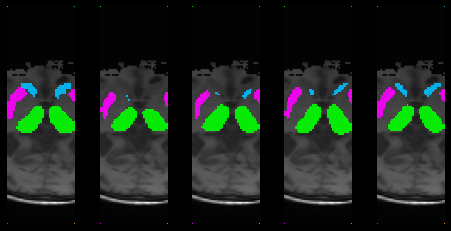

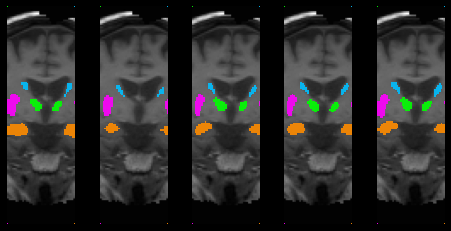

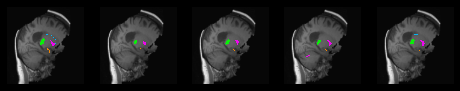

In [ ]:
"""for z in range(60, 80):
    print(z)
    z,y,x = 67, 69, 8 # x = 38
    paper_visual(input_image[0], segs, axis=0, x=x, y=y, z=z)"""

z,y,x = 67, 69, 8 

paper_visual(input_image[0], segs, axis=0, x=x, y=y, z=z, save_name="paper_brain_0.jpg")
paper_visual(input_image[0], segs, axis=1, x=x, y=y, z=z, save_name="paper_brain_1.jpg")
paper_visual(input_image[0], segs, axis=2, x=x, y=y, z=z, save_name="paper_brain_2.jpg")


## 5.3 Plotting training curves

Use data aug: False | Use autoencoder: False
Use data aug: False | Use autoencoder: True
Use data aug: True | Use autoencoder: False
Use data aug: True | Use autoencoder: True


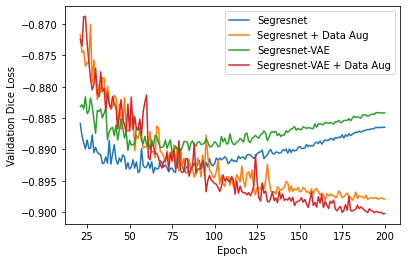

In [ ]:
import matplotlib
#save_directory = "models_200/"

loss_dict = {}

for _use_data_augmentation in [False, True]:
    for _use_autoencoder in [False, True]:
        print(f"Use data aug: {_use_data_augmentation} | Use autoencoder: {_use_autoencoder}")

        handle = f"aug={_use_data_augmentation}_vae={_use_autoencoder}"
        loss_file_name = f'{save_directory}losses_{handle}.pickle'

        with open(loss_file_name, 'rb') as handle:
            losses = pickle.load(handle)
        loss_dict[(_use_data_augmentation, _use_autoencoder)] = np.array(losses).T


for start in [20]:
    its = np.linspace(1, len(losses), len(losses))[start:]
    
    plt.figure()
    plt.plot(its, loss_dict[(False,False)][5,start:], label="Segresnet")#, color="black", label='Vanilla')
    plt.plot(its, loss_dict[(True,False)][5,start:], label="Segresnet + Data Aug")#, color="red", linestyle="dashed", label='Vanilla + Data Aug')
    plt.plot(its, loss_dict[(False,True)][5,start:], label="Segresnet-VAE")
    plt.plot(its, loss_dict[(True,True)][5,start:], label="Segresnet-VAE + Data Aug")
    #plt.plot(its, loss_dict[(False,True)][6,start:] + loss_dict[(False,True)][7,start:], color=u'#2ca02c', label= 'Segresnet-VAE')#, color="blue")
    #plt.plot(its, loss_dict[(True,True)][6,start:] + loss_dict[(True,True)][7,start:], color=u'#d62728', label= 'Segresnet-VAE + Data Aug')#, color="crimson", linestyle="dashed")
    plt.xlabel('Epoch')
    plt.ylabel('Validation Dice Loss')
    #ax = plt.gca()
    #ax.set_ylim([0, 1.5])
    plt.legend()
    
    #plt.subplots_adjust(left=-0.15)
    plt.savefig(f"results/validation_dice_losses_200_start_{start}.jpg", dpi=300, bbox_inches=matplotlib.transforms.Bbox([[-1, -1],[10,10]]))
    plt.show()




#del net
#gc.collect()

## 5.4 Image reconstruction

Data source: IOP
0 Data loaded successfully. X shape is (1, 1, 40, 128, 128)
Use data aug: False | Use autoencoder: True
Use data aug: True | Use autoencoder: True
(1, 40, 128, 128)
(1, 40, 128, 128)
(1, 40, 128, 128)


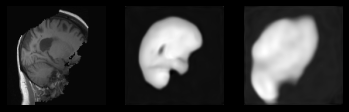

In [ ]:
save_directory = "/content/drive/MyDrive/healthcare_data/models_200/"

for data_source in ["IOP"]: # , "IOP", "HH"]:
    print(f"Data source: {data_source}")
    
    value = 53
    
    X_test = np.load(subcort_handle(f"X_{data_source}"))
    y_test = np.load(subcort_handle(f"y_{data_source}"))
    
    brain_check = np.load(brain_ext_handle(f"X_{data_source}"))
    mask = np.load(brain_ext_handle(f"y_{data_source}"))
    
    if data_source == "Guys":
        guys_length = 317
        val_num = int(guys_length * 0.1) + int(guys_length * 0.8 )
        X_test, y_test = X_test[val_num:guys_length], y_test[val_num:guys_length]
        brain_check, mask = brain_check[val_num:guys_length], mask[val_num:guys_length]
    
    if data_source == "HH":
        hh_length = 176
        X_test, y_test = X_test[:hh_length], y_test[:hh_length]
        brain_check, mask = brain_check[:hh_length], mask[:hh_length]
    
    assert(np.all((brain_check - X_test)==0))
    X_test = X_test * mask

    X_test = np.expand_dims(X_test, 1)
    
    X_test = X_test[value:value+1]
    y_test = y_test[value:value+1]
    
    del brain_check, mask
    gc.collect()
    
    y_test = to_one_hot(y_test, 4, True)
    
    print(f"Data loaded successfully. X shape is {X_test.shape}")
    
    input_image = X_test[:1]
    true = y_test[:1]
    
    _use_autoencoder = True
    
    brains = [input_image[0]]
        
    for _use_data_augmentation in [False, True]:
        print(f"Use data aug: {_use_data_augmentation} | Use autoencoder: {_use_autoencoder}")

        handle = f"aug={_use_data_augmentation}_vae={_use_autoencoder}"
        model_best_name = f"{save_directory}{handle}_best_model"

        net = RegUNet(in_channels=1, init_features=8, out_channels=4,
                        vae_path=_use_autoencoder).float().to(device)
        net.load_state_dict(torch.load(model_best_name))
        net.eval()


        output = net(normalize_one_image(torch.Tensor(input_image)).to(device))[1]
        output = output.detach().cpu().numpy()
        
        brains.append(output[0])
        
        del net
        gc.collect()
    
    x,y,z = 8, 69, 67
    paper_brain_reconstructed(brains, x,y,z, "reconstruction.jpg")


  




In [ ]:

def paper_brain_reconstructed(brains, x=30, y=64, z=64, save_name=None):
    fig = plt.figure()
    fig.patch.set_facecolor('black')
    for i in range(3):
        print(brains[i].shape)
        plt.subplot(1,3,i+1)
        plt.imshow(np.rot90(brains[i][0,x,:,:]), cmap='gray')
        plt.axis('off')

    if save_name is not None:
        plt.savefig(save_name, dpi=1200)
    plt.show()
